In [1]:
#-----Import  packages

import io
import os
import re
import json
import multiprocessing
import time
import nltk
#nltk.download()
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import collections

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import sklearn.ensemble
import sklearn.metrics
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime import lime_text
from sklearn.pipeline import make_pipeline


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import tree, ensemble, linear_model
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report



### Load the data  and EDA

In [2]:
path = r"C:\Users\oadejo\Desktop\Initial Dataset.csv"
df= pd.read_csv(path)

In [3]:
print(df.head())
print(df.shape)

                                         Description           Category
0                                     Access control  Special Rate Pool
1                      Access door to service riser   Special Rate Pool
2                          Access panels to wc walls  Special Rate Pool
3  Additional access panels for cisterns and HVAC...  Special Rate Pool
4             Additional channelling for floor boxes  Special Rate Pool
(6667, 2)


In [4]:
# Number in each category
df['Category'].value_counts()
#collections.Counter(y)

Ineligible           3577
Main Pool            2072
Special Rate Pool     543
Revenue               474
Name: Category, dtype: int64

In [5]:
Visualise  distribution in each category
fig = plt.figure(figsize=(8,6))
colors = ['grey','green','red','darkblue']
df.groupby('Category').Description.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF DESCRIPTION IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

SyntaxError: invalid syntax (<ipython-input-5-1fecdab3e616>, line 1)

In [6]:
# Number missing value
print("Number of missing value in Description: {}".format (df["Description"].isnull().sum()))
print("Number of missing value in Description: {}".format (df["Category"].isnull().sum()))

Number of missing value in Description: 1
Number of missing value in Description: 1


In [7]:
## create a new encoded column
col = [ 'Description','Category']
df1 = df[col]
df1 = df1[pd.notnull(df1['Description'])]
df1.columns = ['Description','Category']
df1['category_id'] = df1['Category'].factorize()[0]
category_id_df = df1[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df1.head()

,Description,Category,category_id
0,Access control,Special Rate Pool,0
1,Access door to service riser,Special Rate Pool,0
2,Access panels to wc walls,Special Rate Pool,0
3,Additional access panels for cisterns and HVAC...,Special Rate Pool,0
4,Additional channelling for floor boxes,Special Rate Pool,0


In [8]:
# remove the missing value in the dataframe
df1=df1.dropna()

In [9]:
# Rechecking the numbers of null
df1.isnull().sum()

Description    0
Category       0
category_id    0
dtype: int64

## Text Pre-processing
* Clean the data
* Remove punctuation
* Tokenization
* Remove stopword
* Vectorizer

### Remove punctuation 

In [10]:

import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
def remove_punct(Description):
    Description="".join([char for char in Description if char not in string.punctuation])
    return Description

In [12]:
df1["text_clean"] = df1["Description"].apply(lambda x: remove_punct(x))
df1.head()

,Description,Category,category_id,text_clean
0,Access control,Special Rate Pool,0,Access control
1,Access door to service riser,Special Rate Pool,0,Access door to service riser
2,Access panels to wc walls,Special Rate Pool,0,Access panels to wc walls
3,Additional access panels for cisterns and HVAC...,Special Rate Pool,0,Additional access panels for cisterns and HVAC...
4,Additional channelling for floor boxes,Special Rate Pool,0,Additional channelling for floor boxes


### Tokenize

In [13]:
# Split  sentences into list of words
import re
def tokenize(text):
    tokens=re.split( '\W+', text)
    return tokens

df1['text_tokenized']=df1['text_clean'].apply(lambda x: tokenize(x.lower()))
df1.head()

,Description,Category,category_id,text_clean,text_tokenized
0,Access control,Special Rate Pool,0,Access control,"[access, control]"
1,Access door to service riser,Special Rate Pool,0,Access door to service riser,"[access, door, to, service, riser, ]"
2,Access panels to wc walls,Special Rate Pool,0,Access panels to wc walls,"[access, panels, to, wc, walls]"
3,Additional access panels for cisterns and HVAC...,Special Rate Pool,0,Additional access panels for cisterns and HVAC...,"[additional, access, panels, for, cisterns, an..."
4,Additional channelling for floor boxes,Special Rate Pool,0,Additional channelling for floor boxes,"[additional, channelling, for, floor, boxes]"


### Remove Stopwords
 * Removing irrelavant words

In [14]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oadejo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
def remove_stopwords(tokenized_text):
    text=[word for word in tokenized_text if word not in stopwords]
    return text
df1['text_nostop']=df1['text_tokenized'].apply(lambda x: remove_stopwords(x))

df1.head()

,Description,Category,category_id,text_clean,text_tokenized,text_nostop
0,Access control,Special Rate Pool,0,Access control,"[access, control]","[access, control]"
1,Access door to service riser,Special Rate Pool,0,Access door to service riser,"[access, door, to, service, riser, ]","[access, door, service, riser, ]"
2,Access panels to wc walls,Special Rate Pool,0,Access panels to wc walls,"[access, panels, to, wc, walls]","[access, panels, wc, walls]"
3,Additional access panels for cisterns and HVAC...,Special Rate Pool,0,Additional access panels for cisterns and HVAC...,"[additional, access, panels, for, cisterns, an...","[additional, access, panels, cisterns, hvac, r..."
4,Additional channelling for floor boxes,Special Rate Pool,0,Additional channelling for floor boxes,"[additional, channelling, for, floor, boxes]","[additional, channelling, floor, boxes]"


# Single function to do cleaning, tokenize and remove stopwords
* Instead of following the above steps, one can use just this single function to achieve thesame result

In [16]:
def clean_text(Description):
    Description="".join([char for char in Description if char not in string.punctuation])
    tokens=re.split( '\W+', Description)
    Description=[word for word in tokens if word not in stopwords]
    return Description

## Apply TFIDF Vectorizer   and Machine Learning
* Change the  words to numbers

In [17]:

X= df1['Description']
y= df1['Category']


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2, random_state=40)

# making class names shorter
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:]) for x in y_train]
class_names = 'Ineligible'
class_names =  "Main Pool"
class_names = 'Special Rate Pool'
class_names =  "Revenue"



In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

vec = TfidfVectorizer(min_df=3, stop_words='english',
                      ngram_range=(1, 2))
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lsa = make_pipeline(vec, svd)

clf = SVC(C=150, gamma=2e-2, probability=True)
pipe = make_pipeline(lsa, clf)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7976011994002998

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)


tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english', lowercase=False)
tfidf_vectorizer.fit(X_train)

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


print("Train/Test Vector Size : ", X_train_tfidf.shape, X_test_tfidf.shape)

rf = RandomForestClassifier()

rf.fit(X_train_tfidf, y_train)

print("Test  Accuracy : %.2f"%rf.score(X_test_tfidf, y_test))
print("Train Accuracy : %.2f"%rf.score(X_train_tfidf, y_train))
print()
print("Confusion Matrix : ")
print(confusion_matrix(y_test, rf.predict(X_test_tfidf)))
print()
print("Classification Report")
print(classification_report(y_test, rf.predict(X_test_tfidf)))

Train/Test Vector Size :  (4999, 2632) (1667, 2632)
Test  Accuracy : 0.83
Train Accuracy : 0.99

Confusion Matrix : 
[[832  28  17  17]
 [ 95 413   2   8]
 [ 58   7  52   2]
 [ 35  15   1  85]]

Classification Report
                   precision    recall  f1-score   support

       Ineligible       0.82      0.93      0.87       894
        Main Pool       0.89      0.80      0.84       518
          Revenue       0.72      0.44      0.54       119
Special Rate Pool       0.76      0.62      0.69       136

         accuracy                           0.83      1667
        macro avg       0.80      0.70      0.74      1667
     weighted avg       0.83      0.83      0.82      1667



## Feature Permutation

In [20]:
import eli5
eli5.show_weights(rf, vec=tfidf_vectorizer, targets=[0,1], target_names=['Ineligible', "Main Pool",'Special Rate Pool',"Revenue"], top=15)

Weight,Feature
0.0251 ± 0.0206,bar
0.0160 ± 0.0153,wall
0.0139 ± 0.0178,Install
0.0131 ± 0.0095,lighting
0.0127 ± 0.0150,counter
0.0125 ± 0.0119,unit
0.0121 ± 0.0082,Clean
0.0110 ± 0.0082,shelves
0.0108 ± 0.0120,tiles
0.0107 ± 0.0111,Supply


In [21]:
import eli5
from eli5.sklearn import PermutationImportance

perm=PermutationImportance(rf,random_state=0).fit(X_test_tfidf, y_test)
eli5.show_weights(perm, feature_names =X_test_tfidf.columns.toarray())

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

# For Loop

In [22]:
# Example 1

numbers = [2, 3, 5, 7]

for number in numbers:
    print(number)

2
3
5
7


In [24]:
# Example 2
fruits = ['apple', 'mango', 'carrot', 'orange','yam']

for fruit in fruits:
    print(fruit)

apple
mango
carrot
orange
yam


In [37]:
# Example 3
my_list = [1,2,3,4,5,6,7,9]

for item in my_list:
    if item < 4:
       print("cool number")
else:
       print('rubbish number')
    

cool number
cool number
cool number
rubbish number


In [43]:
# if-else and if-elif-else statements


x = 2
if x > 0:
    print("x is greater than 0")
else:
    print("x is negative")


x is greater than 0


In [44]:
x = 1
if x == 1:
    print(x)
elif x == 3:
    print(x)
else:
    print("error")

1


In [46]:
my_list = [1,2,3,4,5]
for x in my_list:
    if x == 1:
        print(x)
    elif x == 3:
        print(x)
    else:
        print("wrong numbers")

1
wrong numbers
3
wrong numbers
wrong numbers


###  Complex  Loop

In [1]:
my_movies = [['How I Met Your Mother', 'Friends', 'Silicon Valley'],
    ['Family Guy', 'South Park', 'Rick and Morty'],
    ['Breaking Bad', 'Game of Thrones', 'The Wire']]

In [2]:
for sublist in my_movies:
    for movie_name in sublist:
        char_num = len(movie_name)
        print("The title " + movie_name + " is " + str(char_num) + " characters long.")

The title How I Met Your Mother is 21 characters long.
The title Friends is 7 characters long.
The title Silicon Valley is 14 characters long.
The title Family Guy is 10 characters long.
The title South Park is 10 characters long.
The title Rick and Morty is 14 characters long.
The title Breaking Bad is 12 characters long.
The title Game of Thrones is 15 characters long.
The title The Wire is 8 characters long.


<b>Check out another task:</b>
<p>
Go through all the numbers up until 99. Print ‘fizz’ for every number that’s divisible by 3, print ‘buzz’ for every number divisible by 5, and print ‘fizzbuzz’ for every number divisible by 3 and by 5! If the number is not divisible either by 3 or 5, print a dash (‘-‘)!

In [3]:
for i in range(100):
    if i % 3 == 0 and i % 5 == 0:
        print('fizzbuzz')
    elif i % 3 == 0:
        print('fizz')
    elif i % 5 == 0:
        print('buzz')
    else:
        print('-')


fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz
buzz
-
fizz
-
-
fizzbuzz
-
-
fizz
-
buzz
fizz
-
-
fizz


# Word Cloud generator

In [63]:
from PIL import Image

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS


In [64]:
###  ?WordCloud  ## to understand   all  what you can do with wordcloud

In [67]:
# Load text data
text = '''SUMMARY 
I am a professionally certified Advanced Analyst and Data Scientist with 5+ years’ experience in managing, modelling and analysis of different data and databases for bringing solution to various business problems. I am outgoing, detail-oriented and seeking for organization to leverage my exemplary leadership skills, analytical skills, and coding skills to achieve business goals.
                                             
SKILLS

















WORK HISTORY

 KPMG, UNITED KINGDOM.
Senior Data Analyst  (Assistant Manager) | Glasgow, Scotland | May 2021- Current

•	Extraction, pre-processing and analysing of Client data using different analytic platforms
•	Carry out exploratory data analysis and proof of concept for clients and  stakeholders
•	Exploration, development and review of a variety of machine learning and data analytics tools for the team and in delivery of proprietary product to the clients
•	Development of  Proof-of-concepts with new models emerging in the market

•	Design and development of machine learning models to help enhance the organizational performance and bring more value to our customers
•	Development and Design of model for text classification and NLP
•	Development of machine learning model for Time series data using Xgboost, Twitter, ARIMA and Isolation Forest algorithm 
•	Work with team of BI Developers to develop and deliver visualizations dashboard that provide key insights to the management and clients.
•	Contribute to the wider organization Data Science technical capabilities by sharing knowledge, experience, ideas, and findings
•	Collaborate and lead a team that covers a broad range of data capabilities including data visualization, data management, data migration, data architecture, data integration and data modelling.
•	Lead, manage and mentor a team of other junior colleagues in the area of application of machine learning in different sections of the organization.
•	Develop learning and certification pathway for new and junior colleagues to enhance their development and  career progression within the organization.
•	Providing technical support and supervision assistance to team members
•	Use my people management experience to lead combined project teams of client and KPMG data analytics professionals and develop knowledge in the KPMG team.



SCOTTISH WATER, SCOTLAND.
Senior Data Scientist | Glasgow, Scotland | June 2020- February 2021

•	Extraction, pre-processing and analysing of organisation water and waste (time series) data in Azure platform
•	Design and development of machine learning models to help enhance the organizational performance and bring more value to our customers
•	Development of machine learning model for Time series data using Xgboost, Twitter, ARIMA and Isolation Forest algorithm 
•	Optimization of maintenance of company infrastructure.
•	Provide expertise in analytics and statistics across the company’s project
•	Designing and implementing data science solution as modelling using AutoML on Microsoft Azure
•	Design and development of different visualization dashboard and Apps necessary for the project using PowerBI and PowerApp
•	Development of software and data science projects using Agile and scrum solution development practices.
•	Technical mentoring and knowledge sharing with members of the team.
•	Modelling and application development using Scrum/Agile delivery methodology


AYRSHIRE COLLEGE SCOTLAND.
Data Scientist | Ayr, Scotland | October 2018- May 2020

•	Extraction, pre-processing and analysing of data from different sources using different open source and bespoke commercial software such as Excel, SPSS, R and Python
•	Designing of different dashboard for measuring performance and other business requirement from key stakeholders across multiple business units within the organization using Qlikview and PowerBI
•	Interpret and manage data and solve complex problems using expertise in a variety of data. 
•	Supporting leaders and system developers in creating better products and paradigms for the organization
•	Using different machine learning approach to classify historical data and predict students’ academic outcomes as well as discover underlying patterns in their behaviours.
•	Identification and development of new data analytic approach and techniques to uncover hidden insights and enhance organisation performance
•	Writing and presenting different KPI and managerial report to management board for decision making.
•	Provide technical expertise to the team, bringing new ideas from academia and industry to the wider organization.


UNIVERSITY OF THE WEST OF SCOTLAND.
Research Analyst and Technician | Paisley, Scotland | April 2018- September, 2018

•	Systematic research and acquisition of literature, facts and statistics for the e-health project 
•	Contribute to the design and development of rule engine and system (Clinical Decision Support System) for diagnosing and treatment of disease in e-health project. 
•	Contribute to the development of an authoring tool (web app using Angular) to make Clinical Decision Support apps more flexible and customizable.
•	Data analysis and modelling using Python and R languages
•	Conference and journal paper preparation and publication.


BORDERS COLLEGE, SCOTLAND.
Lecturer Computing Science | Galashiels, Scotland | August 2017 – March 2018

•	Lecturer in Computing Science and Digital Media.
•	Teach different modules/units such as Programming in Python, Database management, Information system, Network literacy, Digital Multimedia and Software development.
•	Lecture on how to use machine learning tools and statistical techniques to produce solutions to problems.
•	Teach students on how to create and write reports that tells compelling stories about customers or clients work with businesses.
•	Lecture on how combined knowledge of computer science and applications modelling, statistics, analytics and maths to solve problems 
•	Develop curriculum, lesson plans, assessments and research in accordance with SQA guideline as well as assist in course monitoring and review.

GRAZT TRAINING & CONSULTING LTD
Data Analyst / Scientist | Glasgow, Scotland | September 2015 - May 2017

•	Undertaking data collection from primary or secondary data sources, pre-processing and analysis of data and make reports and made recommendations based on findings.
•	Conducting full lifecycle analysis to include requirements specification and design. 
•	Responsible for loading, extracting and validation of client’s data
•	Carrying out specified data processing using different software and statistical techniques such as SPSS, Weka, Rapidminer
•	Utilizes efficiencies of internal document management application such as Google drive and SharePoint.
•	Build predictive models and machine-learning algorithms to address business problems
•	Combine models using different ensemble techniques to address organisational problems
•	Present information using data visualization techniques and preparing organisation performance reports
•	 Develop strong analytical and reporting system to bring solution to complex data set for varied set of users
•	Execute projects involving analytics and implemented processes that improve and lead to greater data quality.
•	Carry out complex analysis on multi-dimensional datasets with a variety of tools and statistical analysis environments such as R, SPSS.
•	Data Analysis with vast experience in rational database such as with Hadoop-based data mining framework.
•	As consultant I provide insight into leading analytic practices, designs and also lead in iterative learning and development cycles.
•	Carryout research, design, implement and validate cutting-edge algorithms to analyse data to achieve targeted outcomes.
•	Source and acquire data from primary or secondary data sources and maintain databases/data 


REDEEMED CHRISTIAN CHURCH OF GOD.
Database & Digital Media Administrator | Paisley, Scotland | November 2011 - August 2015

•	Design, development and maintenance of organisational website
•	Developed e-commerce websites for affiliates of the organisation
•	Design and maintain organisational database system
•	Create a content calendar which will return maximum ROI for the client 
•	Manage all aspects of the content marketing process, ensuring all content is promoted to the right audience


MELBOURNE OIL SERVICING LTD.
Data Analyst / Database Administrator | Warri, Nigeria | September 2003 - July 2007

•	Gathering, extracting and compiling data to analyse customer acquisition process using Excel and SPSS packages
•	Keeping records of contract, procurement and supply of material, oil servicing technical and servicing information, utilities control and maintenance 
•	Data entry, data auditing, creating data reports & monitoring all data for accuracy
•	Performing daily system checks.
•	Work with management to prioritize business and information needs
•	Interpreting data, analyzing results using statistical techniques

CASPIAN ENGINEERING LIMITED
Junior Data Analyst | Lagos, Nigeria | March 2001 - June 2003

•	Manipulate, cleaning and processing data using Excel, Access and SQL
•	Collaborate with business analyst and finance departments to design objective to achieve thorough data automation
•	Automate weekly productivity reports to send to finance department
•	Liaising with end users and third-party suppliers
•	Analyzing raw data, drawing conclusion and developing recommendations
•	Performing daily system checks
•	Preparing of monthly performance and management reports


EDUCATION    

PHD Computing Science University of the West of Scotland, Paisley (Obtained, 2017)
                                                                                                             (UK, 2014 -2017)
•	Thesis Title: Datamining and Learning Analytic- A multi-model approach to Predicting Student Performance using Aggregated Data Sources
•	Supervisor: Prof Thomas Connolly

MSC Information Technology Application Development (with Distinction) 
                                                                  University of Sunderland (UK, 2010-2011)
•	Modules includes: E-Commerce and Web development, Object oriented programming, Human Computer Interaction, Network development, Security and Privacy, Database Management and Information system analysis techniques.
HNC (Computing) North Glasgow College (UK, 2008-2010)   
•	Modules includes: Application software, Relational Databases, Operating system, Computer Architecture, Computer hardware installation and Maintenance.
Advanced Diploma (Computer science) Leicester College of Professional studies
                                                                                London (UK,2007-2008)
•	 Modules includes: Database management, Applied Programming, Digital logic design, Computer application and operation.
          
BSC (Agricultural Economics) University of Calabar, Nigeria (Jan 1993 – Sept 1998)
•	Modules includes: Principle of Econometric, Microeconomics and Macroeconomics, Agricultural economics and finance, Program planning and evaluation.
 
 
 Short Courses, Certifications and Personal Development
•	Microsoft Certified: Azure AI Fundamentals -2021
•	Microsoft Certified: Data Analyst Associate -2021
•	Microsoft Certified: Azure Data Fundamental-2021
•	Microsoft Certified: Power Platform Fundamental-2021
•	NVIDIA Certificate in Application of AI for Predictive Maintenance -2020
•	Microsoft Certified: Data Science Associate -2019
•	Certificate in Big Data and Hadoop Essentials from Udemy
•	Microsoft Azure: Architecting Azure Infrastructure -2019
•	Microsoft Azure: Design and Deploy ARM Templates -2019
•	Advanced SQL for Data Scientists certificate -2019
•	Certificate in Data Analysis with Python from IBM's Big Data University -2019
•	Certificate in Machine Learning with Python from IBM's Big Data University -2019
•	Certificate in Applied Data Science with Python from IBM's Big Data University -2019
•	Certificate in Machine Learning in R from IBM's Big Data University -2018
•	Certificate in Data Science Methodology from IBM's Big Data University -2018
•	Certificate in Data Visualization in R from IBM's Big Data University -2018
•	Two-weeks intensive and specialize training on Data mining for Data Science, University of Jyvaskyla, Finland. - August 2016
•	Advanced Certification in Leadership of John Maxwell Institute of Leadership, USA 

                                                                                                            
PROFESSIONAL MEMBERSHIP
•	Member IEEE (Membership No-92113780)
•	Member Association of Computer Machinery ACM (Membership No-7834672)
•	Certified Member of Data Science Association
•	Associate Editor, International Journal of Virtual and Personal Learning Environments (IJVPLE)
•	Associate Editor, International Journal of Information Technology and Economic Development (IJITED)
      
   PUBLICATION

•	More than 15 peer reviewed publications in International conferences and journals across the world. Available on Researchgate and Google scholar

 
  REFEREES

   Available on request

'''

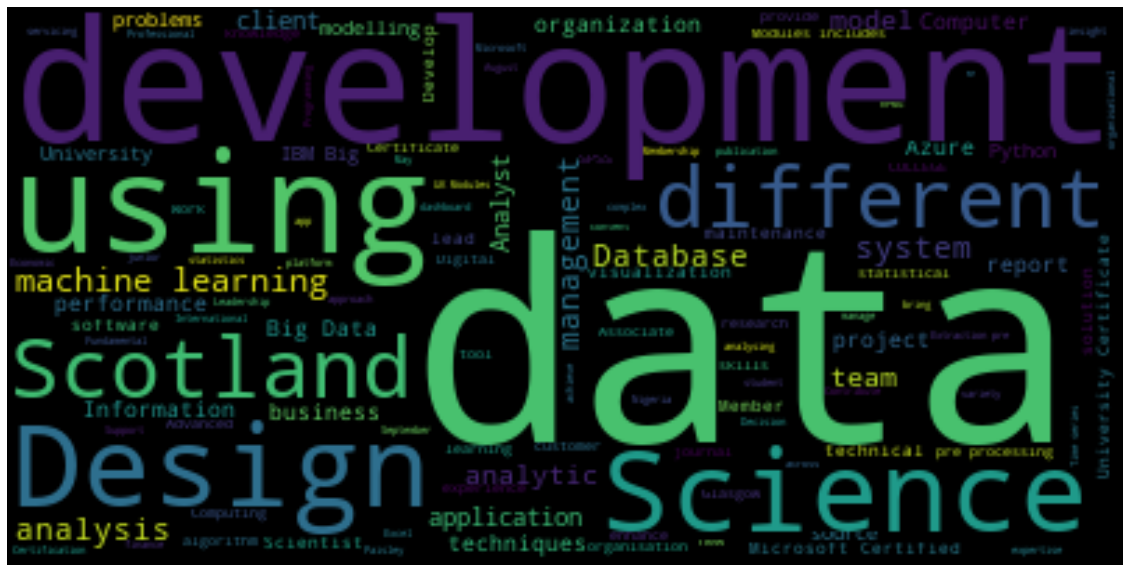

In [74]:
# Create stopword list

stopwords= set(STOPWORDS)
wordcloud=WordCloud (max_font_size=100, stopwords=stopwords,
                     background_color='black', max_words=300,
                     contour_color='black', contour_width=3)

# Generate  word cloud
wordcloud.generate(text)

# Visualise the word cloud

wordcloud.to_image()
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation ="bilinear")
plt.axis('off')
plt.show()